In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
import segmentation_models as sm

2022-12-09 12:59:59.965877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 13:00:03.142485: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-09 13:00:03.142870: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-09 13:00:03.142904: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Segmentation Models: using `tf.keras` framework.


In [3]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/danimar301@student.polsl.pl/Extraterrestial-Rock-Segmentation")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1048085717579938', creation_time=1668775123782, experiment_id='1048085717579938', last_update_time=1669805000133, lifecycle_stage='active', name='/Users/danimar301@student.polsl.pl/Extraterrestial-Rock-Segmentation', tags={'mlflow.experiment.sourceName': '/Users/danimar301@student.polsl.pl/Extraterrestial-Rock-Segmentation',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'danimar301@student.polsl.pl',
 'mlflow.ownerId': '7796760964070965'}>

In [4]:
# Prepare paths of input images and target segmentation masks
input_dir = "./Datasets/Mars_Rocks/MarsData-main/Data/Rock-B/Images/Rock-B/"
target_dir = "./Datasets/Mars_Rocks/MarsData-main/Data/Rock-B/label/"

img_size = (320,320)


input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")
])

#Sorting mask names in target folder
target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")
])

print("Number of input samples:", len(input_img_paths))
print("Number of target samples:", len(target_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of input samples: 204
Number of target samples: 204
./Datasets/Mars_Rocks/MarsData-main/Data/Rock-B/Images/Rock-B/1044_1044MR0045730180204466E01_DXXX.jpg | ./Datasets/Mars_Rocks/MarsData-main/Data/Rock-B/label/1044_1044MR0045730180204466E01_DXXX.png
./Datasets/Mars_Rocks/MarsData-main/Data/Rock-B/Images/Rock-B/1044_1044MR0045730190204467E01_DXXX.jpg | ./Datasets/Mars_Rocks/MarsData-main/Data/Rock-B/label/1044_1044MR0045730190204467E01_DXXX.png
./Datasets/Mars_Rocks/MarsData-main/Data/Rock-B/Images/Rock-B/1044_1044MR0045730480204496E01_DXXX.jpg | ./Datasets/Mars_Rocks/MarsData-main/Data/Rock-B/label/1044_1044MR0045730480204496E01_DXXX.png
./Datasets/Mars_Rocks/MarsData-main/Data/Rock-B/Images/Rock-B/1044_1044MR0045730490204497E01_DXXX.jpg | ./Datasets/Mars_Rocks/MarsData-main/Data/Rock-B/label/1044_1044MR0045730490204497E01_DXXX.png
./Datasets/Mars_Rocks/MarsData-main/Data/Rock-B/Images/Rock-B/1047_1047ML0046000200306022E01_DXXX.jpg | ./Datasets/Mars_Rocks/MarsData-main/Data/Rock

In [5]:
# auxiliary utility functions
def extract_mask_from_ground(ground_img, lower_color_threshold):
    (R, G, B) = cv2.split(ground_img)
    
    # Values are clipped to 2 as it corresponds to 'small rock' class
    R_ranged = np.clip(cv2.inRange(R, lower_color_threshold, 255), 0, 2) 
    G_ranged = np.clip(cv2.inRange(G, lower_color_threshold, 255), 0, 2) 
    B_ranged = np.clip(cv2.inRange(B, lower_color_threshold, 255), 0, 2)

    merged = cv2.merge([B_ranged, G_ranged, R_ranged])
    merged = np.expand_dims(merged, 3)
    merged = np.amax(merged, axis=2)
    return merged

# The threshold value determines how many small rocks are visible, higher threshold means less blue rocks
def load_ground(path, color_threshold):
    img_ground = cv2.imread(path)
    img_ground_rgb = cv2.cvtColor(img_ground, cv2.COLOR_BGR2RGB)
    img_ground_rgb = cv2.resize(img_ground_rgb, img_size[::-1])
    return extract_mask_from_ground(img_ground_rgb, color_threshold)

Input image: 


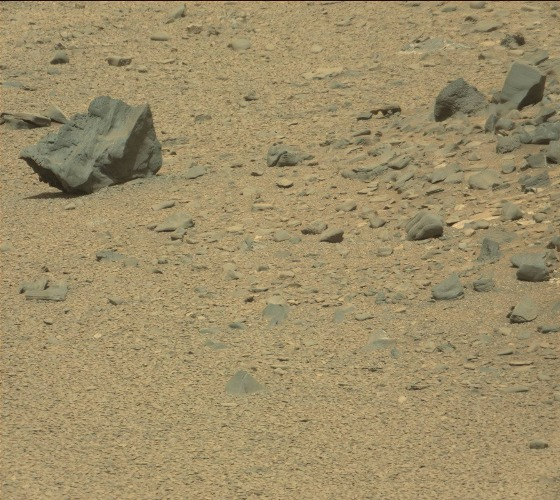

Target image: 


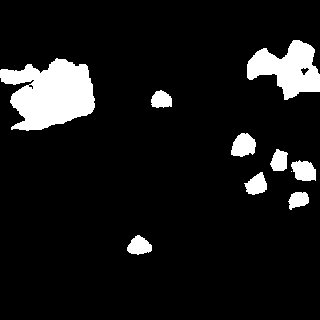

(320, 320, 1)
[0 2]


In [6]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

image_index = 8

# Display input image 
print("Input image: ")
display(Image(filename=input_img_paths[image_index], width = 320, height = 320))

print("Target image: ")
img_ground = load_ground(target_img_paths[image_index], 1)
display(tf.keras.preprocessing.image.array_to_img(img_ground))

print(img_ground.shape)
print(np.unique(img_ground))

In [7]:
class MartianRocks(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, color_threshold):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.color_threshold = color_threshold
        
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        # Returns tuple (input, target) corresponding to batch idx
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        # 3 Dimensional input images
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size = self.img_size)
            x[j] = img
                
        # 1 Dimensional target mask
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            # load ground imahe
            y[j] = load_ground(path, self.color_threshold)
                
        return x, y


<class 'tuple'>
[0 2]
<class 'numpy.uint8'>


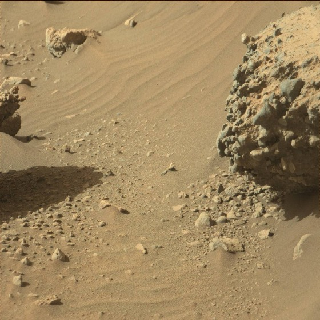

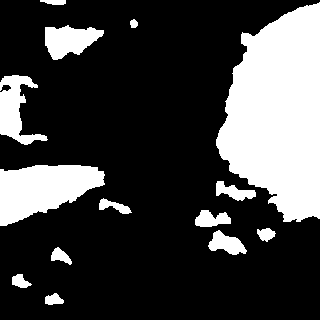

In [10]:
loader = MartianRocks(
            16, img_size, input_img_paths[:1000], 
            target_img_paths[:1000], color_threshold = 1)

print(type(loader.__getitem__(3)))
print(np.unique(loader.__getitem__(1)[1][1]))
print(type(loader.__getitem__(1)[1][3][0][0][0]))
batch = loader.__getitem__(4)
display(tf.keras.preprocessing.image.array_to_img(batch[0][1]))
display(tf.keras.preprocessing.image.array_to_img(batch[1][1]))

In [8]:
from segmentation_models.losses  import bce_jaccard_loss
from segmentation_models.metrics import IOUScore

run_id = 0

# This line downloads models from mlflow artifacts
temp_dir = mlflow.artifacts.download_artifacts(
    'dbfs:/databricks/mlflow-tracking/1048085717579938/93af11203abf4ee8a6f74f2d860c794a/artifacts/model')
print(temp_dir)
model = keras.models.load_model(temp_dir + '/data/model', compile=False)
model.summary()

/tmp/tmp5si97kn2/model


2022-12-09 13:07:11.221963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 13:07:11.437249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 13:07:11.437812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 13:07:11.442682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 321, 321, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 160, 160, 32  864         ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv_dw_5 (DepthwiseConv2D)    (None, 40, 40, 256)  2304        ['conv_pw_4_relu[0][0]']         
                                                                                                  
 conv_dw_5_bn (BatchNormalizati  (None, 40, 40, 256)  1024       ['conv_dw_5[0][0]']              
 on)                                                                                              
                                                                                                  
 conv_dw_5_relu (ReLU)          (None, 40, 40, 256)  0           ['conv_dw_5_bn[0][0]']           
                                                                                                  
 conv_pw_5 (Conv2D)             (None, 40, 40, 256)  65536       ['conv_dw_5_relu[0][0]']         
                                                                                                  
 conv_pw_5

 ion)                                                                                             
                                                                                                  
 conv_pw_10_relu (ReLU)         (None, 20, 20, 512)  0           ['conv_pw_10_bn[0][0]']          
                                                                                                  
 conv_dw_11 (DepthwiseConv2D)   (None, 20, 20, 512)  4608        ['conv_pw_10_relu[0][0]']        
                                                                                                  
 conv_dw_11_bn (BatchNormalizat  (None, 20, 20, 512)  2048       ['conv_dw_11[0][0]']             
 ion)                                                                                             
                                                                                                  
 conv_dw_11_relu (ReLU)         (None, 20, 20, 512)  0           ['conv_dw_11_bn[0][0]']          
          

                                                                                                  
 decoder_stage1a_conv (Conv2D)  (None, 40, 40, 128)  589824      ['decoder_stage1_concat[0][0]']  
                                                                                                  
 decoder_stage1a_bn (BatchNorma  (None, 40, 40, 128)  512        ['decoder_stage1a_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage1a_relu (Activati  (None, 40, 40, 128)  0          ['decoder_stage1a_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage1b_conv (Conv2D)  (None, 40, 40, 128)  147456      ['decoder_stage1a_relu[0][0]']   
          

 decoder_stage4b_relu (Activati  (None, 320, 320, 16  0          ['decoder_stage4b_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 final_conv (Conv2D)            (None, 320, 320, 4)  580         ['decoder_stage4b_relu[0][0]']   
                                                                                                  
 sigmoid (Activation)           (None, 320, 320, 4)  0           ['final_conv[0][0]']             
                                                                                                  
Total params: 8,336,772
Trainable params: 8,312,900
Non-trainable params: 23,872
__________________________________________________________________________________________________


In [11]:
preds = model.predict(loader)

2022-12-09 13:09:27.459048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2022-12-09 13:09:30.472587: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-09 13:09:31.598975: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


12/12 [==============================] - 13s 448ms/step


2022-12-09 13:09:37.559825: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 314572800 exceeds 10% of free system memory.


In [12]:
from skimage import color
# Display results for validation image with index i

def get_mask(i, preds):
    #Quick utilization to display a model's prediction

    mask = np.argmax(preds[i], axis=2)
    mask = np.expand_dims(mask, axis=-1)
    mask = np.clip(mask, 0, 2)
    # img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
    return mask

def show_results(index, input_paths, target_paths, predictions):
    # Load input image
    # print(input_paths[index])
    # print(target_paths[index])
    original = cv2.imread(input_paths[index])
    display(tf.keras.preprocessing.image.array_to_img(original))
    original = cv2.resize(original, img_size)

    #Load ground-truth target mask
    target = load_ground(target_paths[index], 1)

    target_img = tf.keras.preprocessing.image.array_to_img(target)


    # Display mask predicted by model
    pred_mask = get_mask(index, predictions)

    pred_mask_img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(pred_mask))

    # Applay segmentation mask onto real image
    final_predicted = color.label2rgb(np.asarray(pred_mask_img), original, bg_label=0)
    final_target = color.label2rgb(np.asarray(target_img), original, bg_label=0)

    # Stack segmentation masks on real images
    final = np.hstack((final_target, final_predicted))

    # Stack only masks
    pred_mask = np.hstack((target, pred_mask))
    display(PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(pred_mask))) 

    display(tf.keras.preprocessing.image.array_to_img(final))

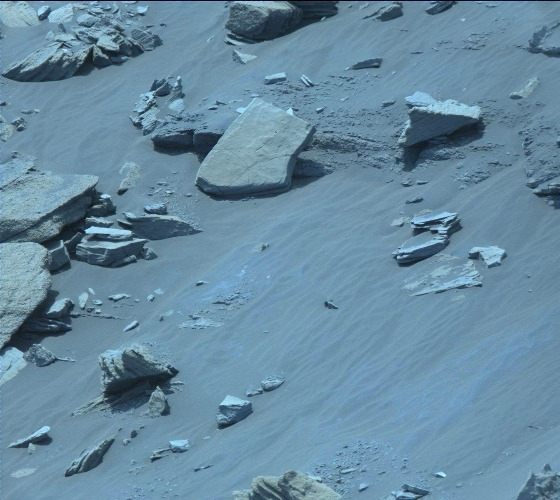

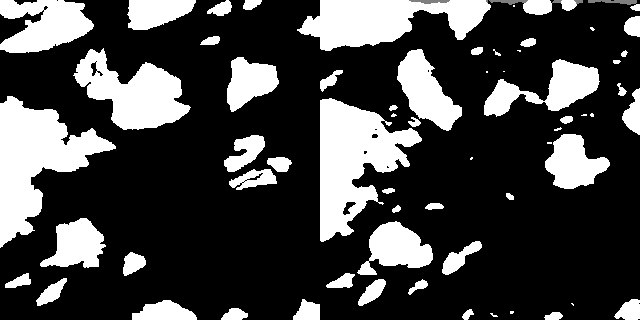

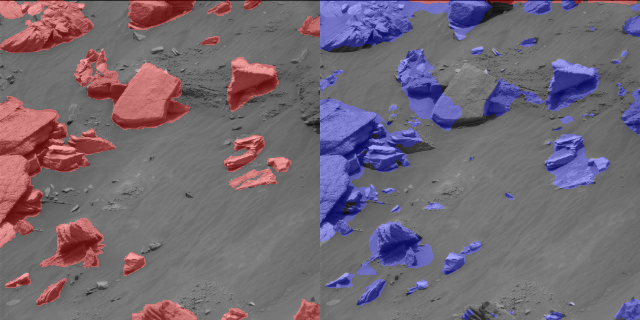

In [13]:
i = 89

show_results(i, input_img_paths, target_img_paths, preds)

In [38]:
# Utility function for evaluating models performance with any given metric
import keras.backend as K

# Calculate dice coefficent for one input array
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Calculate average dice loss for every label
def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice = [0, 0, 0]
    result = 0
    average = 0
    for index in range(numLabels):
        result = dice_coef(y_true[:,:,index], y_pred[:,:,index]) # @Todo: Zbierać dice score dla każdej klasy
        # print("Dice score for class {}: {}".format(index, result))
        dice[index] += result
        average += result
    return (dice, average/numLabels) # taking average

#@todo: make function for evaluating dice loss
def calculate_dice_loss(preds, target_paths, color_threshold=1):
    result = [0,0,0]
    average = []
    for i, mask in enumerate(preds):
        mask = np.argmax(mask, axis=2)
        mask = np.expand_dims(mask, axis=-1)
        mask = np.clip(mask, 0, 2)
        target = cv2.imread(target_paths[i])
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        target = cv2.resize(target, img_size[::-1])
        target = extract_mask_from_ground(target, color_threshold)

      #One hot encoding so the Dice coefficent works
        mask = tf.one_hot(mask, 3)
        mask = np.squeeze(mask, axis=2)
        target = tf.one_hot(target, 3)
        target = np.squeeze(target, axis=2)
#         print(mask.shape)
#         print(target.shape)
        dice_coef_tuple = dice_coef_multilabel(target, mask, 3)
        average.append(dice_coef_tuple[1])
        for i, value in enumerate(dice_coef_tuple[0]):
            result[i] += value

    for i, value in enumerate(result):
        print("Dice score for class {}: {}".format(i, value/len(preds)))
    return average

# Calculate metrics for all model predictions, returns a list 
def evaluate_model(preds, target_paths_here, metric, color_threshold=1):
    result = []
    metric.reset_states()
    for i, mask in enumerate(preds):
        mask = np.argmax(mask, axis=2)
        mask = np.expand_dims(mask, axis=-1)
        mask = np.clip(mask, 0, 2)
#         print(np.unique(mask))
        target = cv2.imread(target_paths_here[i])
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        target = cv2.resize(target, img_size[::-1])
        target = extract_mask_from_ground(target, color_threshold)

        metric.update_state(target, mask)
        result.append(metric.result().numpy())
    return result



In [39]:
meanIoU = tf.keras.metrics.MeanIoU(num_classes=4)
accuracy = tf.keras.metrics.Accuracy()
rmse = tf.keras.metrics.RootMeanSquaredError()

dice_score = np.mean(calculate_dice_loss(preds, target_img_paths))
iou = np.mean(evaluate_model(preds, target_img_paths, meanIoU))
accuracy =  np.mean(evaluate_model(preds, target_img_paths, accuracy))
rmse = np.mean(evaluate_model(preds, target_img_paths, rmse))

print("Dice score: {}".format(dice_score))
print("Mean IoU: {}".format(iou))
print("Accuracy: {}".format(accuracy))
print("RMSE: {}".format(rmse))


Dice score for class 0: 0.8083628553491845
Dice score for class 1: 0.30729291492168814
Dice score for class 2: 0.5315448020313868
Dice score: 0.5490668574340866
Mean IoU: 0.3686554431915283
Accuracy: 0.7559426426887512
RMSE: 0.9814289212226868
